In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchnet.meter as tnt
import importlib

from scipy.io.wavfile import write
import IPython

sys.path.append('../')
sys.path.append('../datasets')
sys.path.append(os.path.join(os.getcwd(), '../models/'))

import ai8x
from kws20_d import KWS
import kws20_d
from msnoise import MSnoise
import msnoise

In [167]:
data_path = '/home/emretopcu/ai8x-training/data'

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

simulate = False
args = Args(act_mode_8bit=simulate)
_, test_speech = kws20_d.KWS_20_get_datasets((data_path, args), load_train=False, load_test=True)
_, test_noise = msnoise.MSnoise_get_datasets((data_path, args), load_train=False, load_test=True)

No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]
Processing the label: backward. 1 of 36


Finished in 0.267 seconds.
Processing the label: bed. 2 of 36
Finished in 0.326 seconds.
Processing the label: bird. 3 of 36
Finished in 0.331 seconds.
Processing the label: cat. 4 of 36
Finished in 0.327 seconds.
Processing the label: dog. 5 of 36
Finished in 0.342 seconds.
Processing the label: down. 6 of 36
Finished in 0.632 seconds.
Processing the label: eight. 7 of 36
Finished in 0.617 seconds.
Processing the label: five. 8 of 36
Finished in 0.661 seconds.
Processing the label: follow. 9 of 36
Finished in 0.255 seconds.
Processing the label: forward. 10 of 36
Finished in 0.253 seconds.
Processing the label: four. 11 of 36
Finished in 0.601 seconds.
Processing the label: go. 12 of 36
Finished in 0.623 seconds.
Processing the label: happy. 13 of 36
Finished in 0.332 seconds.
Processing the label: house. 14 of 36
Finished in 0.339 seconds.
Processing the label: learn. 15 of 36
Finished in 0.256 seconds.
Processing the label: left. 16 of 36
Finished in 0.607 seconds.
Processing the la

In [3]:
print("Number of utterance samples:", len(test_speech))
print("Number of noise samples:", len(test_noise))

Number of utterance samples: 11005
Number of noise samples: 15802


In [4]:
classes_speech = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
                   'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero',
                   'UNKNOWN']

classes_noise = ['AirConditioner', 'AirportAnnouncements',
               'Babble', 'Bus', 'CafeTeria', 'Car',
               'CopyMachine', 'Metro',
               'Office', 'Restaurant', 'ShuttingDoor',
               'Traffic', 'Typing', 'VacuumCleaner', 'Washing']

In [5]:
def plot_audio(data, target, classes, snr=None):
    plt.plot(data)
    if snr != None:
        plt.title("Noisy", classes[target])
        plt.legend("SNR: ", snr)
    else:
        plt.title(classes[target])
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

In [6]:
def random_sample(data_set,data_type):
    if data_type == 'train':
        sample_index = np.random.randint(0,len(data_set))

        sample, target = data_set[sample_index]
        print(f'target: {target}, sample index: {sample_index}')
    if data_type == 'test':
        sample_index = np.random.randint(0,len(data_set))

        sample, target = data_set[sample_index]
        print(f'target: {target}, sample index: {sample_index}')
    return sample, target, sample_index

In [7]:
def snr_mixer2(clean, noise_1, noise_2=None, multiple=False, snr=10):
    # Normalizing to rms equal to 1
    rmsclean = np.mean(clean**2)**0.5
    scalarclean = 1 / rmsclean
    clean = clean * scalarclean

    if multiple==False:
        rmsnoise = np.mean(noise_1**2)**0.5
        scalarnoise = 1 / rmsnoise
        noise = noise_1 * scalarnoise
    else:
        rmsnoise = np.mean((noise_1 + noise_2)**2)**0.5
        scalarnoise = 1 / rmsnoise
        noise = (noise_1 + noise_2) * scalarnoise

    # Set the noise level for a given SNR
    cleanfactor = 10**(snr/20)
    noisyspeech = cleanfactor*clean + noise
    noisyspeech = noisyspeech / (scalarnoise + cleanfactor * scalarclean)
    return noisyspeech

In [ ]:
# AirConditioner        0    - 1634
# AirportAnnouncements  1635 - 2784
# Babble                2785 - 6114
# Bus                   6115 - 7311
# CafeTeria             7312 - 8508
# Car                   8509 - 9705
# CopyMachine           9706 - 9789
# Metro                 None - None
# Office                None - None
# Restaurant            None - None
# ShuttingDoor          9790 - 10813
# Traffic               10814 - 12010
# VacuumCleaner         14109 - 14604 
# Washing               14605 - 15801

In [225]:
speech_sample, speech_target = test_speech[2000]
speech_sample = np.array(speech_sample)
speech_sample = speech_sample.flatten('F')

noise_sample, noise_target = test_noise[2785]
noise_sample = np.array(noise_sample)
noise_sample = noise_sample.flatten('F')

noise_sample_1, noise_target_1 = test_noise[7429]
noise_sample_1 = np.array(noise_sample_1)
noise_sample_1 = noise_sample_1.flatten('F')

In [207]:
write('test_speech.wav', 16000, speech_sample)
print(f'target class info: {classes_speech[speech_target]}')
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test_speech.wav')

target class info: five


In [208]:
write('test_noise.wav', 16000, noise_sample)
print(f'target class info: {classes_noise[noise_target]}')
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test_noise.wav')

target class info: Babble


In [226]:
write('test_noise_1.wav', 16000, noise_sample_1)
print(f'target class info: {classes_noise[noise_target_1]}')
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test_noise_1.wav')

target class info: CafeTeria


In [245]:
noisy_speech = snr_mixer2(speech_sample, noise_sample,snr=12)

In [246]:
write('test_noisy_speech.wav', 16000, noisy_speech)
print(f'target class info: {classes_speech[speech_target]}, and {classes_noise[noise_target]}')
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test_noisy_speech.wav')

target class info: five, and Babble


In [239]:
noisy_speech_multiple = snr_mixer2(speech_sample, noise_sample_1, noise_sample, multiple=True,snr=12)

In [240]:
write('test_noisy_speech_multiple.wav', 16000, noisy_speech_multiple)
print(f'target class info: {classes_speech[speech_target]}, {classes_noise[noise_target]} and {classes_noise[noise_target_1]}')
IPython.display.Audio('/home/emretopcu/ai8x-training/notebooks/test_noisy_speech_multiple.wav')

target class info: five, Babble and CafeTeria


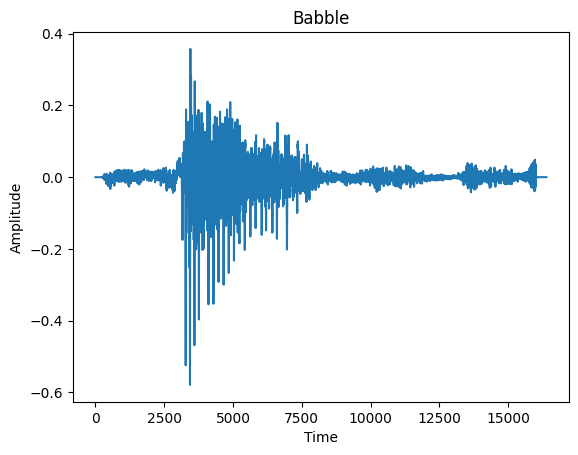

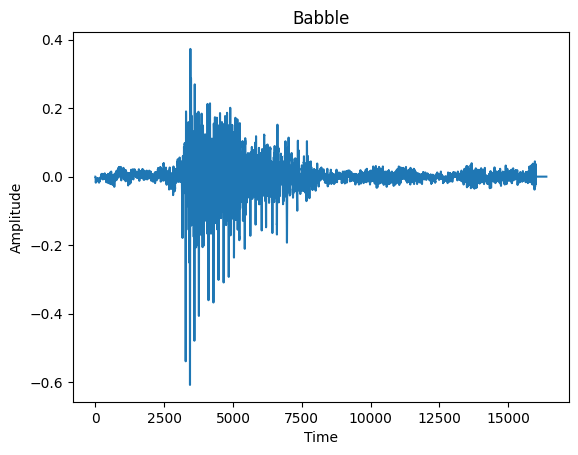

In [244]:
plot_audio(noise_sample, noise_target, classes_noise)

plot_audio(noise_sample_1, noise_target_1, classes_noise)

plot_audio(speech_sample, speech_target, classes_speech)

plot_audio(noisy_speech, noise_target, classes_noise)

plot_audio(noisy_speech_multiple, noise_target, classes_noise)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=simulate, round_avg=False)

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [33]:
# Existing version
strategy_a = os.path.join("..", ".." ,"ai8x-synthesis", "trained", "ai85-kws20-qat8.pth.tar")
# Updated DataLoader
strategy_b = os.path.join("..", "logs", "train_strategy_b_upd_v1", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector
strategy_c = os.path.join("..", "logs", "train_strategy_c_upd_utt_v1", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector + 66% augment chance
strategy_d = os.path.join("..", "logs", "train_strategy_d_upd_utt_66_v1", "qat_best.pth.tar")
strats = [strategy_a, strategy_b, strategy_c, strategy_d]

In [19]:
mod = importlib.import_module("ai85net-kws20")
model = mod.AI85KWS20Net(num_classes=len(classes_speech), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

In [20]:
# AirConditioner        0    - 1634
# AirportAnnouncements  1635 - 2784
# Babble                2785 - 6114
# Bus                   6115 - 7311
# CafeTeria             7312 - 8508
# Car                   8509 - 9705
# CopyMachine           9706 - 9789
# Metro                 None - None
# Office                None - None
# Restaurant            None - None
# ShuttingDoor          9790 - 10813
# Traffic               10814 - 12010
# VacuumCleaner         14109 - 14604 
# Washing               14605 - 15801

In [21]:
def snr_mixer(clean, noise_1, noise_2=None, multiple=False, snr=10):
    # Normalizing to rms equal to 1
    rmsclean = torch.mean(clean**2)**0.5
    scalarclean = 1 / rmsclean
    clean = clean * scalarclean

    if multiple==False:
        rmsnoise = torch.mean(noise_1**2)**0.5
        scalarnoise = 1 / rmsnoise
        noise = noise_1 * scalarnoise
    else:
        rmsnoise = torch.mean((noise_1 + noise_2)**2)**0.5
        scalarnoise = 1 / rmsnoise
        noise = (noise_1 + noise_2) * scalarnoise

    # Set the noise level for a given SNR
    cleanfactor = 10**(snr/20)
    noisyspeech = cleanfactor*clean + noise
    noisyspeech = noisyspeech / (scalarnoise + cleanfactor * scalarclean)
    return noisyspeech

In [22]:
def evaluate(model, test_speech, test_noise, db):

    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes_speech), 5)))
    model.eval()

    batch = torch.zeros(256, 128, 128)
    target_batch = torch.zeros(256)

    n_noise = np.random.randint(2785,6114)
    random_noise, _ = test_noise[n_noise]
    cntr = 1

    with torch.no_grad():
        for validation_step, (inputs, targets) in enumerate(test_speech):
            index_in_batch = np.mod(validation_step, 256)

            inputs = snr_mixer(inputs, random_noise,snr=db)
            inputs = inputs.unsqueeze(0)

            batch[index_in_batch] = inputs
            target_batch[index_in_batch] = targets
            if index_in_batch == 255:
                
                batch = batch.to(device)
                target_batch = target_batch.to(device)
                # compute output from model
                output = model(batch)
                classerr.add(output, target_batch)

                print("Batch: [", cntr*256 ,"/", len(test_speech),"]")
                acc = classerr.value()[0]
                print("Accuracy: ", acc)

                cntr+=1
                n_noise = np.random.randint(2785,6114)
                random_noise, _ = test_noise[n_noise]
                
        batch = batch.to(device)
        target_batch = target_batch.to(device)
        # compute output from model
        output = model(batch)
        classerr.add(output, target_batch)

        print("Batch: [", cntr*256 ,"/", len(test_speech),"]")        
        acc = classerr.value()[0]
        print("Total Accuracy: ", acc)
    return acc

In [34]:
accuracies = np.zeros((len(strats),17))

for i,strat in enumerate(strats):
    print("Started evaluating :", strat)
    checkpoint = torch.load(strat)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    ai8x.update_model(model)

    snr_low = torch.tensor(20, dtype=torch.int32)
    snr_high = torch.tensor(51, dtype=torch.int32)
    cnt = 0

    for db in range(snr_low, snr_high):
        if db <= 20:
            if db % 2 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_speech, test_noise, db)
                cnt += 1
        else:
            if  db % 5 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_speech, test_noise, db)
                cnt += 1

Started evaluating : ../logs/train_strategy_d_upd_utt_66_v1/qat_best.pth.tar
Evaluating SNR levels of 20


Batch: [ 256 / 11005 ]
Accuracy:  85.546875
Batch: [ 512 / 11005 ]
Accuracy:  82.8125
Batch: [ 768 / 11005 ]
Accuracy:  80.859375
Batch: [ 1024 / 11005 ]
Accuracy:  78.41796875
Batch: [ 1280 / 11005 ]
Accuracy:  81.328125
Batch: [ 1536 / 11005 ]
Accuracy:  84.04947916666666
Batch: [ 1792 / 11005 ]
Accuracy:  85.77008928571428
Batch: [ 2048 / 11005 ]
Accuracy:  86.962890625
Batch: [ 2304 / 11005 ]
Accuracy:  87.36979166666666
Batch: [ 2560 / 11005 ]
Accuracy:  84.5703125
Batch: [ 2816 / 11005 ]
Accuracy:  85.6534090909091
Batch: [ 3072 / 11005 ]
Accuracy:  86.10026041666666
Batch: [ 3328 / 11005 ]
Accuracy:  86.71875
Batch: [ 3584 / 11005 ]
Accuracy:  87.109375
Batch: [ 3840 / 11005 ]
Accuracy:  86.58854166666666
Batch: [ 4096 / 11005 ]
Accuracy:  86.23046875
Batch: [ 4352 / 11005 ]
Accuracy:  86.83363970588236
Batch: [ 4608 / 11005 ]
Accuracy:  86.89236111111111
Batch: [ 4864 / 11005 ]
Accuracy:  87.41776315789474
Batch: [ 5120 / 11005 ]
Accuracy:  87.63671875
Batch: [ 5376 / 11005 ]
A

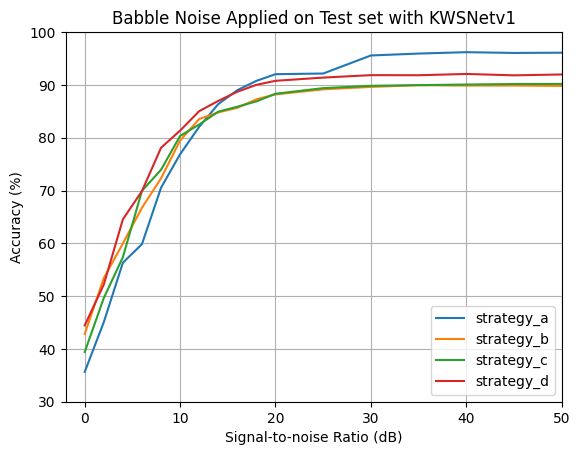

In [198]:
snr_db = np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50])
plt.plot(snr_db,accuracies[0], label = "strategy_a")
plt.plot(snr_db,accuracies[1], label = "strategy_b")
plt.plot(snr_db,accuracies[2], label = "strategy_c")
plt.plot(snr_db,accuracies[3], label = "strategy_d")
plt.title("Babble Noise Applied on Test set with KWSNetv1")
plt.xlim((-2, 50))
plt.ylim((30, 100))
plt.xlabel('Signal-to-noise Ratio (dB)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

### Multiple Noise Mixed ###

In [189]:
# Existing version
#strategy_a_old = os.path.join("..", ".." ,"ai8x-synthesis", "trained", "ai85-kws20_v3-qat8-q.pth.tar")
# Existing Version + Updated Train/Validation Split
strategy_a = os.path.join("..", "logs", "train_strategy_a_old_train+val_v3", "qat_best.pth.tar")
# Updated DataLoader + Updated Train/Validation Split
strategy_b = os.path.join("..", "logs", "train_strategy_b_upd_train+val_v3", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector + Updated Train/Validation Split
strategy_c = os.path.join("..", "logs", "train_strategy_c_upd_train+val_v3", "qat_best.pth.tar")
# Updated DataLoader + Utterance Detector + 66% augment chance + Updated Train/Validation Split
strategy_d = os.path.join("..", "logs", "train_strategy_d_upd_train+val_v3", "qat_best.pth.tar")
strats = [strategy_a, strategy_b, strategy_c, strategy_d]

In [190]:
mod = importlib.import_module("ai85net-kws20-v3")
model = mod.AI85KWS20Netv3(num_classes=len(classes_speech), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

In [191]:
def evaluate(model, test_speech, test_noise, db):

    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes_speech), 5)))
    model.eval()

    batch = torch.zeros(256, 128, 128)
    target_batch = torch.zeros(256)

    n_babble = np.random.randint(2785,6114)
    babble_noise, _ = test_noise[n_babble]
    n_cafe = np.random.randint(7312,8508)
    cafe_noise, _ = test_noise[n_cafe]
    cntr = 1

    with torch.no_grad():
        for validation_step, (inputs, targets) in enumerate(test_speech):
            index_in_batch = np.mod(validation_step, 256)

            inputs = snr_mixer(inputs, babble_noise, cafe_noise, multiple=True, snr=db)
            inputs = inputs.unsqueeze(0)

            batch[index_in_batch] = inputs
            target_batch[index_in_batch] = targets
            if index_in_batch == 255:
                
                batch = batch.to(device)
                target_batch = target_batch.to(device)
                # compute output from model
                output = model(batch)
                classerr.add(output, target_batch)

                print("Batch: [", cntr*256 ,"/", len(test_speech),"]")
                acc = classerr.value()[0]
                print("Accuracy: ", acc)

                cntr+=1
                n_babble = np.random.randint(2785,6114)
                babble_noise, _ = test_noise[n_babble]
                n_cafe = np.random.randint(7312,8508)
                cafe_noise, _ = test_noise[n_cafe]
                
        batch = batch.to(device)
        target_batch = target_batch.to(device)
        # compute output from model
        output = model(batch)
        classerr.add(output, target_batch)

        print("Batch: [", cntr*256 ,"/", len(test_speech),"]")        
        acc = classerr.value()[0]
        print("Total Accuracy: ", acc)
    return acc

In [192]:
accuracies = np.zeros((len(strats),17))

for i,strat in enumerate(strats):
    print("Started evaluating :", strat)
    checkpoint = torch.load(strat)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    ai8x.update_model(model)

    snr_low = torch.tensor(0, dtype=torch.int32)
    snr_high = torch.tensor(51, dtype=torch.int32)
    cnt = 0

    for db in range(snr_low, snr_high):
        if db <= 20:
            if db % 2 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_speech, test_noise, db)
                cnt += 1
        else:
            if  db % 5 == 0:
                print("Evaluating SNR levels of", db)
                accuracies[i][cnt] = evaluate(model, test_speech, test_noise, db)
                cnt += 1

Started evaluating : ../logs/train_strategy_a_old_train+val_v3/qat_best.pth.tar
Evaluating SNR levels of 0


Batch: [ 256 / 11005 ]
Accuracy:  25.390625
Batch: [ 512 / 11005 ]
Accuracy:  33.203125
Batch: [ 768 / 11005 ]
Accuracy:  27.473958333333336
Batch: [ 1024 / 11005 ]
Accuracy:  26.26953125
Batch: [ 1280 / 11005 ]
Accuracy:  35.0
Batch: [ 1536 / 11005 ]
Accuracy:  34.765625
Batch: [ 1792 / 11005 ]
Accuracy:  33.92857142857143
Batch: [ 2048 / 11005 ]
Accuracy:  35.986328125
Batch: [ 2304 / 11005 ]
Accuracy:  36.71875
Batch: [ 2560 / 11005 ]
Accuracy:  34.5703125
Batch: [ 2816 / 11005 ]
Accuracy:  37.39346590909091
Batch: [ 3072 / 11005 ]
Accuracy:  39.908854166666664
Batch: [ 3328 / 11005 ]
Accuracy:  38.581730769230774
Batch: [ 3584 / 11005 ]
Accuracy:  37.58370535714286
Batch: [ 3840 / 11005 ]
Accuracy:  35.83333333333333
Batch: [ 4096 / 11005 ]
Accuracy:  35.64453125
Batch: [ 4352 / 11005 ]
Accuracy:  36.90257352941176
Batch: [ 4608 / 11005 ]
Accuracy:  38.020833333333336
Batch: [ 4864 / 11005 ]
Accuracy:  40.48108552631579
Batch: [ 5120 / 11005 ]
Accuracy:  41.5625
Batch: [ 5376 / 110

KeyboardInterrupt: 

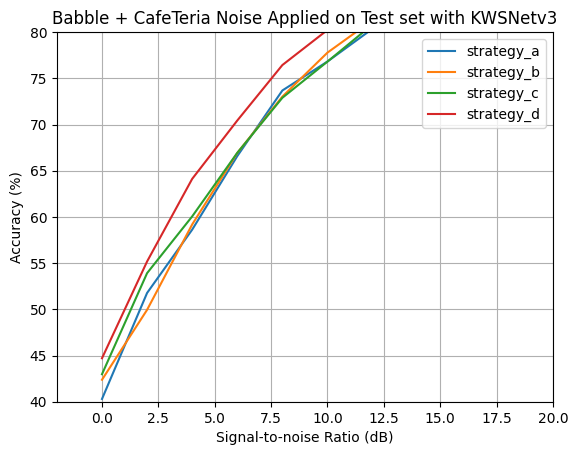

In [248]:
snr_db = np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50])
#plt.plot(snr_db,accuracies[0], label = "strategy_a_old")
plt.plot(snr_db,accuracies[0], label = "strategy_a")
plt.plot(snr_db,accuracies[1], label = "strategy_b")
plt.plot(snr_db,accuracies[2], label = "strategy_c")
plt.plot(snr_db,accuracies[3], label = "strategy_d")
plt.title("Babble + CafeTeria Noise Applied on Test set with KWSNetv3")
plt.xlim((-2, 50))
plt.ylim((30, 100))
plt.xlabel('Signal-to-noise Ratio (dB)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()